**->Download Chunk**
------------------

In [77]:
!aws s3 cp s3://open5gs-respons-logs/prometheus-metrics/respons-amf-forecaster/01H1SRVSY16XHX27E678RP2PZB/ df15 --recursive

download: s3://open5gs-respons-logs/prometheus-metrics/respons-amf-forecaster/01H1SRVSY16XHX27E678RP2PZB/meta.json to df15/meta.json
download: s3://open5gs-respons-logs/prometheus-metrics/respons-amf-forecaster/01H1SRVSY16XHX27E678RP2PZB/chunks/000001 to df15/chunks/000001
download: s3://open5gs-respons-logs/prometheus-metrics/respons-amf-forecaster/01H1SRVSY16XHX27E678RP2PZB/index to df15/index


**->Run main.go to convert meta file to JSON**
--------------------------------------------

**->Dataframe Load + EDA API**
--------------------------------------------

In [136]:
def get_amf_data(json_object_path, column_name = None, pod_id = None):
    obj = Nested_Json_Connector(json_object_path)
    err, data = obj.read_nested_json()
    amf_data = data.filter(col("metric_pod").startswith('open5gs-amf') & (col("metric_namespace")=="openverso"))
    if column_name:
        amf_data.filter(col("metric___name__") == column_name)
    if pod_id:
        amf_data.filter(col("metric_pod") ==  pod_id)
    return amf_data

def transform_dataframe(amf_data):
    # Explode the array of Unix timestamps and values into individual rows
    exploded_df_timestamps = amf_data.select(F.posexplode(amf_data.timestamps).alias("pos", "unix_timestamps"), 'metric_pod', 'metric___name__')
    exploded_df_values = amf_data.select(F.posexplode(amf_data.values).alias("pos", "values"), 'metric_pod', 'metric___name__')
    exploded_df = exploded_df_timestamps.join(exploded_df_values, ["pos", "metric_pod", "metric___name__"])
    
    # Order the DataFrame by the Timestamp column in ascending order
    sorted_df = exploded_df.orderBy("unix_timestamps")
    sorted_df = sorted_df.withColumn("unix_timestamps", F.col("unix_timestamps") / 1000)
    converted_df = sorted_df.withColumn("date_time", F.from_unixtime("unix_timestamps", format='yyyy-MM-dd HH:mm:ss')).drop("unix_timestamps")                                       
    
    #Type Casting
    extracted_df = converted_df.withColumn("date_time", col("date_time").cast(TimestampType()))
    extracted_df = extracted_df.withColumn("values", col("values").cast(FloatType()))
    return extracted_df

def get_values(amf_data, column_name = None, pod_id = None):
    if column_name:
        amf_data = amf_data.filter(col("metric___name__") == column_name)
    if pod_id:
        amf_data = amf_data.filter(col("metric_pod") ==  pod_id)
    amf_data = amf_data.groupBy('date_time', 'metric___name__',  'metric_pod').agg(F.avg('values').alias('avg_values'))
    return amf_data

def comparisson_plot(amf_data, metric1, metric2, pod1, pod2):
    time1 = time.time()
    data1 = get_values(amf_data, metric1, pod1).toPandas()
    data2 = get_values(amf_data, metric2, pod2).toPandas()
    # Create a figure and axis
    fig, ax = plt.subplots()
    # Loop through each metric name and plot its data
    for metric_name, group in data1.groupby('metric___name__'):
        group.plot(x='date_time', y='avg_values', ax=ax, label=metric_name)
    for metric_name, group in data2.groupby('metric___name__'):
        group.plot(x='date_time', y='avg_values', ax=ax, label=metric_name)
    plt.show()
    time2 = time.time()
    print(time2 - time1)

**->Retrive Dataframe**
------------------------

In [59]:
time1 = time.time()
json_object_path = 'df72.json'
data = get_amf_data(json_object_path)
amf_data = transform_dataframe(data)
time2 = time.time()
print(time2 - time1)

Nested_Json_Connector initialized with the following s3_file_path:df72.json
30.445111751556396


**Pod Names**
--------------------------------------------

In [22]:
data.select('metric_pod').rdd.flatMap(lambda x: x).distinct().collect()

['open5gs-amf-6d85b8c465-fzg2t', 'open5gs-amf-54cc5d554b-pjq4v']

Metric Wise Analysis
--------------------

**1. container_blkio_device_usage_total**
--------------------------------------
Blkio, short for Block Input/Output, is a subsystem in the Linux kernel's control groups (cgroups) framework. It provides control and monitoring of input/output operations performed by block devices such as hard drives, solid-state drives (SSDs), and other storage devices.mThe blkio subsystem allows administrators to allocate and limit the amount of input/output bandwidth that processes or groups of processes can utilize. This helps in managing and prioritizing disk access among different applications or containers running on a system. By setting specific rules and constraints on block devices, administrators can regulate the throughput and I/O operations performed by processes or groups of processes. This ensures fair resource allocation and prevents any single process from monopolizing the disk I/O, which could adversely affect the overall system performance. <br>

The Prometheus metric container_blkio_device_usage_total refers to a metric that is collected and exposed by the Prometheus monitoring system for tracking the block I/O device usage of containers. In computer storage, a block device refers to a storage device that is accessed in fixed-size blocks or chunks. These blocks are typically of a uniform size, such as 512 bytes, 4 kilobytes, or 8 kilobytes, depending on the device and the underlying file system. Block devices are used for storing and retrieving data, and they provide a way to organize and manage storage at a low-level, abstracting away the specific details of the underlying storage medium. Examples of block devices include hard disk drives (HDDs), solid-state drives (SSDs), USB drives, and network-attached storage (NAS) devices.<br>

The metric represents the cumulative block I/O usage by a container across all block devices. It provides information about the total number of block I/O operations (reads and writes) performed by the container since its inception.<br>


+-------------------+--------------------+--------------------+----------+
|          date_time|     metric___name__|          metric_pod|avg_values|
+-------------------+--------------------+--------------------+----------+
|2023-06-06 14:00:09|container_blkio_d...|open5gs-amf-6d85b...|  564428.8|
|2023-06-06 14:00:22|container_blkio_d...|open5gs-amf-6d85b...|  564428.8|
|2023-06-06 14:00:39|container_blkio_d...|open5gs-amf-6d85b...|  564428.8|
|2023-06-06 14:00:57|container_blkio_d...|open5gs-amf-6d85b...|  564428.8|
|2023-06-06 14:01:04|container_blkio_d...|open5gs-amf-6d85b...|  564428.8|
|2023-06-06 14:01:21|container_blkio_d...|open5gs-amf-6d85b...|  564428.8|
|2023-06-06 14:01:30|container_blkio_d...|open5gs-amf-6d85b...|  564428.8|
|2023-06-06 14:01:59|container_blkio_d...|open5gs-amf-6d85b...|  564428.8|
|2023-06-06 14:02:09|container_blkio_d...|open5gs-amf-6d85b...|  564428.8|
|2023-06-06 14:02:29|container_blkio_d...|open5gs-amf-6d85b...|  594739.2|
|2023-06-06 14:02:37|cont

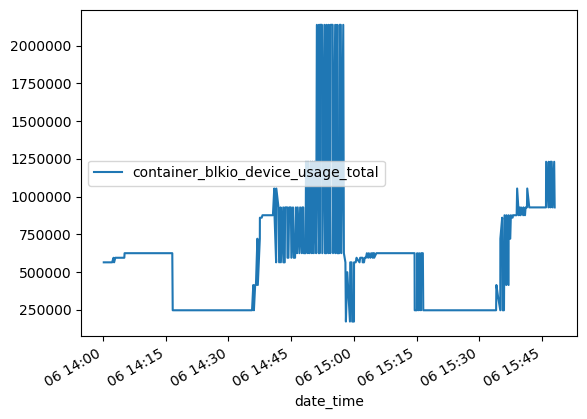

16.79246187210083


In [110]:
#1. container_blkio_device_usage_total vs container_memory_max_usage_bytes
plot_data = get_values(amf_data, 'container_blkio_device_usage_total')
plot_data.orderBy("date_time").show()
print(plot_data.count())
comparisson_plot(amf_data, 'container_blkio_device_usage_total', 'container_blkio_device_usage_total', 'open5gs-amf-6d85b8c465-fzg2t', 'open5gs-amf-54cc5d554b-pjq4v')

**2. container_cpu_load_average_10s**
--------------------------------------
The container_cpu_load_average_10 metric represents the average CPU load of a container over a specific time window, which in this case is 10 seconds. The CPU load generally refers to the amount of computational work being performed by the CPU at a given time, and it is commonly measured as a load average over a certain period.<br>

The unit of the container_cpu_load_average_10 metric in Prometheus is typically the "load average" value, which is a dimensionless quantity representing the average number of processes in the system's run queue or waiting for CPU time over a specific time period.<br>

The load average values are relative measurements and do not have a specific unit like percentage or absolute count. Instead, they indicate the level of CPU utilization relative to the number of available CPU cores. For example, a load average of 1.0 on a single-core system indicates that the CPU is fully utilized, while a load average of 2.0 on a dual-core system suggests that the CPU is handling twice its capacity.<br>

**This could have been a good metric to use but since it's zero throughout, we need to figure out another metric for calcualting utilization.**

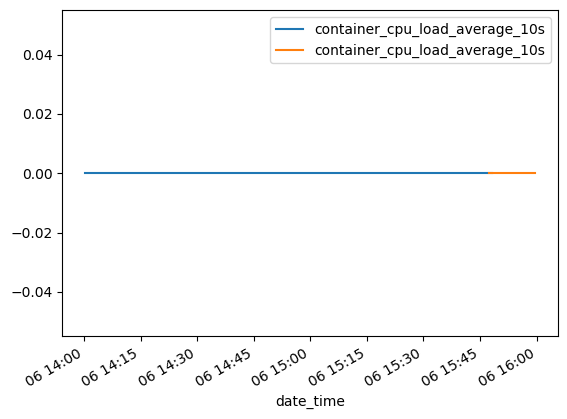

21.806838035583496


In [98]:
comparisson_plot(amf_data, 'container_cpu_load_average_10s', 'container_cpu_load_average_10s', 'open5gs-amf-6d85b8c465-fzg2t', 'open5gs-amf-54cc5d554b-pjq4v')

**3. container_cpu_system_seconds_total**
--------------------------------------
This metric represents the total CPU time, in seconds, spent **in kernel space** by container processes. Kernel space refers to the protected area of the operating system where the kernel and device drivers reside.<br>

cpu_system_seconds indicates the measurement of CPU time spent in kernel space. Helps in understanding the system-level impact of container processes on CPU resources.<br>



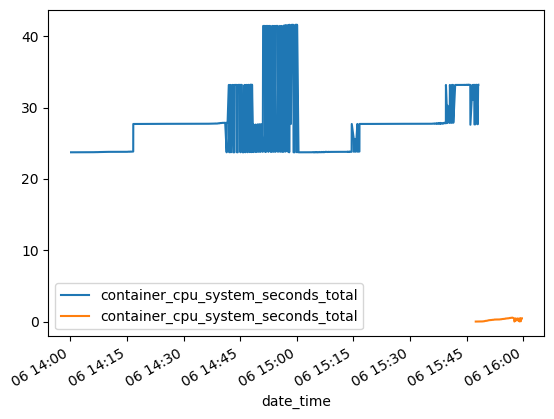

21.95138955116272


In [99]:
comparisson_plot(amf_data, 'container_cpu_system_seconds_total', 'container_cpu_system_seconds_total', 'open5gs-amf-6d85b8c465-fzg2t', 'open5gs-amf-54cc5d554b-pjq4v')

**4. container_cpu_user_seconds_total**
--------------------------------------
The container_cpu_user_seconds_total metric is used to monitor and measure the cumulative CPU time in seconds consumed by container processes **in user space** within a containerized environment. This metric specifically represents the amount of CPU time used by container processes in user mode, excluding any time spent in the kernel.<br>

The container_cpu_user_seconds_total metric helps in understanding the amount of CPU time utilized by container processes specifically in user space. It can be used to analyze and optimize the user-mode CPU consumption of containers, providing insights into the workload's computational demands.<br>


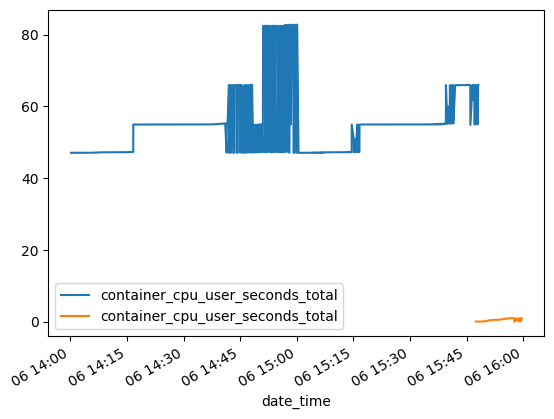

22.986032485961914


In [101]:
comparisson_plot(amf_data, 'container_cpu_user_seconds_total', 'container_cpu_user_seconds_total', 'open5gs-amf-6d85b8c465-fzg2t', 'open5gs-amf-54cc5d554b-pjq4v')

**5. container_cpu_usage_seconds_total**
--------------------------------------
The container_cpu_usage_seconds_total metric is used to monitor and measure the **cumulative** CPU usage in seconds by container processes within a containerized environment. The container_cpu_usage_seconds_total metric is typically used to calculate CPU utilization or monitor resource consumption patterns<br>

To calculate the CPU utilization from the container_cpu_system_seconds_total metric, you need to compare the difference in values between two time intervals. Here's the general process: <br><br>

- Record the initial value of container_cpu_system_seconds_total at the start of the time interval you want to measure.
- Wait for a specific duration, such as 1 second, 5 seconds, or any desired interval.
- Record the final value of container_cpu_system_seconds_total after the duration has passed.
- Calculate the difference between the final and initial values.
- Divide the difference by the duration of the interval to get the average CPU utilization.
- Here's the formula for calculating CPU utilization:

**CPU Utilization = (Final Value - Initial Value) / Duration**

For example, let's say you record the initial value as 100 seconds and after waiting for 5 seconds, the final value is 120 seconds. The duration is 5 seconds.<br>

CPU Utilization = (120 - 100) / 5 = 4 seconds per second or 400%<br>

In this example, the CPU utilization is 400%, indicating that the container processes, on average, consumed the equivalent of 4 CPU cores during that 5-second interval.<br>

**During feature enginering we will have to agree on an intereval and calcualte the utilization and use that as a feature**

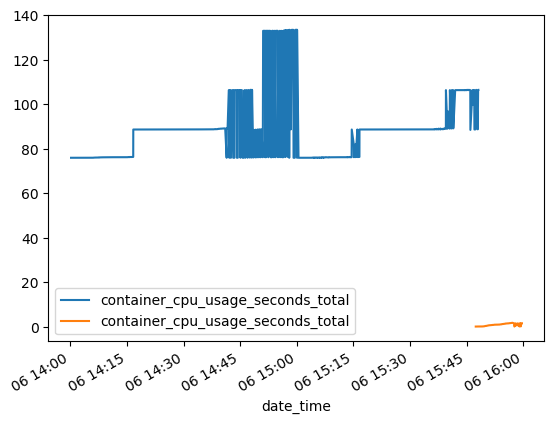

20.882940530776978


In [100]:
comparisson_plot(amf_data, 'container_cpu_usage_seconds_total', 'container_cpu_usage_seconds_total', 'open5gs-amf-6d85b8c465-fzg2t', 'open5gs-amf-54cc5d554b-pjq4v')

**NOTE: container_cpu_system_seconds_total vs container_cpu_user_seconds_total vs container_cpu_usage_seconds_total**
------------------------------------------------------------------------------------------------------------------
**container_cpu_system_seconds_total:**

- Measures the cumulative CPU time in seconds spent in kernel space by container processes.
- Focuses on the time spent in the kernel by container processes.
- Represents system-level CPU usage specific to container processes.
- Excludes user space CPU time.
- Helps understand the impact of container processes on the system's kernel.

**container_cpu_user_seconds_total:**
- Measures the cumulative CPU time in seconds consumed in user space by container processes.
- Specifically focuses on the time spent in user mode by container processes.
- Excludes kernel space CPU time.
- Represents the CPU utilization of container processes in user space.

**container_cpu_usage_seconds_total:**
- Measures the cumulative CPU usage in seconds by container processes.
- Represents the total CPU time used by container processes, including both user and system time.
- Includes both user and kernel space CPU time.
- Provides insights into the overall CPU utilization of containers.
<br><br>
**container_cpu_name_seconds_total:** This is the full name of the metric, indicating that it pertains to CPU usage by container processes in given space.<br>
**container:** Refers to the specific container being monitored. Each container typically has a unique identifier or name. <br>
**cpu_user_seconds:** Represents the measurement of CPU time used by container processes in user mode. <br>
total: Indicates the cumulative or aggregated value since the start of monitoring or the last reset. <br>

**6. container_file_descriptors**
--------------------------------------
A file descriptor is a unique identifier or reference used by operating systems to access files, sockets, or other I/O (input/output) resources. It is an abstract representation of an open file or I/O channel. In most operating systems, including Unix-like systems such as Linux, file descriptors are non-negative integers. They serve as a means for processes to interact with files and I/O devices. When a process opens a file or creates a socket, the operating system assigns a file descriptor to that resource. File descriptors allow processes to perform operations such as reading from or writing to files, sending or receiving data over network sockets, or manipulating other types of I/O resources. Processes use file descriptors as handles to access these resources, issuing system calls to perform various operations. The operating system maintains a table, called the file descriptor table or file table, which associates file descriptors with the corresponding open files or I/O resources. Each process has its own file descriptor table, which is managed by the operating system. <br>

File descriptors have a limited range, typically determined by the operating system. This limitation means that a process can only have a certain number of open files or I/O resources at any given time. If a process exceeds this limit, it may encounter issues such as being unable to open additional files or experiencing resource contention. <br>

The container_file_descriptors metric in Prometheus is used to monitor the number of file descriptors being used by container processes within a containerized environment. The container_file_descriptors metric provides insights into the file descriptor usage of containerized applications and can help in identifying potential resource constraints or leaks. It is typically reported as a **gauge metric**, representing the current number of open file descriptors.The metric name container_file_descriptors does not have a "_total" suffix, as it represents a current state rather than a cumulative value. <br>

As file descriptors are handles used by processes to access files, sockets, or other I/O resources. They facilitate input/output operations but do not directly impact CPU or memory consumption. However, it is worth noting that excessive file descriptor usage could indirectly affect CPU or memory utilization if it leads to inefficiencies or resource contention within the container. For example, if a container process opens a large number of file descriptors but does not efficiently manage or close them, it could result in increased system resource usage, such as CPU time spent on handling I/O operations or memory consumed by keeping track of open file descriptors. So it can be used as a diagnostic tool to identify potential issues that might indirectly impact resource usage within a container. 


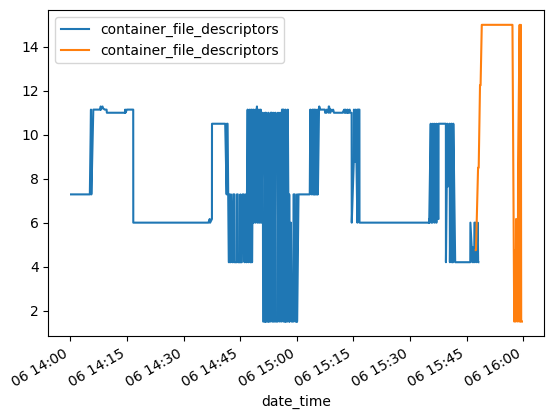

23.164575576782227


In [102]:
comparisson_plot(amf_data, 'container_file_descriptors', 'container_file_descriptors', 'open5gs-amf-6d85b8c465-fzg2t', 'open5gs-amf-54cc5d554b-pjq4v')

**7. container_fs_reads_bytes_total**
--------------------------------------
In containerized environments, container file systems refer to the file systems that are used by containers to store and manage their application files, libraries, and dependencies. Each container typically has its own isolated file system, which provides a contained environment for the execution of the containerized application. <br>

Container file system reads, as measured by the container_fs_reads_bytes_total metric in Prometheus, refer to the number of bytes read from the file system by container processes. Whenever a containerized application reads data from files within its file system, such as reading configuration files, accessing libraries, or retrieving application data, these operations contribute to the container file system reads metric.This metric provides insights into the volume and pattern of data access from the file system by container processes over time.<br>

Note that the container_fs_reads_bytes_total metric represents the cumulative sum of bytes read from the filesystem. To calculate the rate of filesystem reads per unit of time, you can use Prometheus query functions like rate() or irate() to derive the instantaneous or average rate of bytes read from the filesystem per second or any desired time interval. <br>

**Excessive file system reads could potentially impact CPU and memory utilization in the following ways:**
CPU utilization: If a container performs frequent and intensive file system read operations, it may require the CPU to process and handle these read requests, which can increase CPU usage.
Memory utilization: When data is read from the file system, it is typically loaded into memory for processing by the application. If there are large amounts of data being read, it may occupy memory resources within the container, potentially impacting memory utilization.<br>

We will have to do a correlation analysis to see if this data will actually help when taken along with more important metrics like container_cpu_usage_seconds_total and container_memory_usage_bytes

Q. How come Pod 2 did not have any file system reads during its 15 mins ?


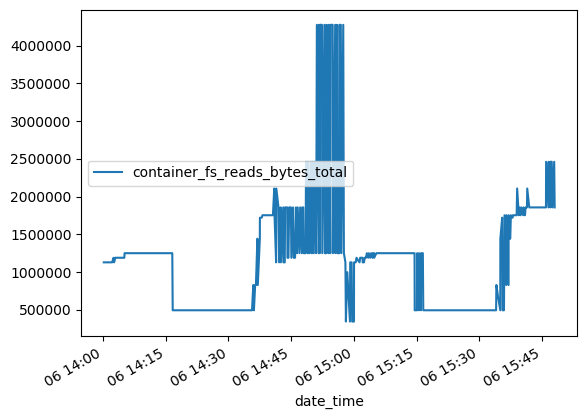

15.72944164276123


In [121]:
comparisson_plot(amf_data, 'container_fs_reads_bytes_total', 'container_fs_reads_bytes_total', 'open5gs-amf-6d85b8c465-fzg2t', 'open5gs-amf-54cc5d554b-pjq4v')

**8. container_fs_reads_total**
--------------------------------------
The container_fs_reads_total metric is a counter that increments each time a container process reads data from the file system. It provides insights into the overall read workload of the container, helping monitor file system access patterns and potential performance bottlenecks related to reading files.<br>

File system reads involve I/O operations, which can consume CPU cycles and require memory for buffering or caching data. Therefore, monitoring CPU and memory utilization alongside file system read metrics can provide a more comprehensive understanding of resource usage patterns within the container.<br>


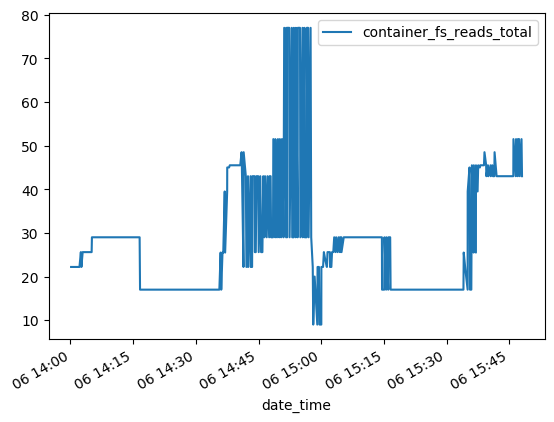

15.794719934463501


In [120]:
comparisson_plot(amf_data, 'container_fs_reads_total', 'container_fs_reads_total', 'open5gs-amf-6d85b8c465-fzg2t', 'open5gs-amf-54cc5d554b-pjq4v')

**9. container_fs_writes_bytes_total**
--------------------------------------
Container file system writes refer to the operations in which container processes write data to the file system within a containerized environment. When a containerized application creates, modifies, or deletes files or directories within its file system, these actions are considered file system writes. These write operations allow containerized applications to store and persist data, update configurations, log information, and perform other file-related activities. <br>

This metric represents the total number of bytes written to the file system by container processes over time. Monitoring additional metrics related to CPU and memory, such as container_cpu_usage_seconds_total and container_memory_usage_bytes, can provide a more comprehensive view of resource utilization in relation to file system write operations.<br>

Q. How come Pod 2 did not have any file system reads during its 15 mins ?



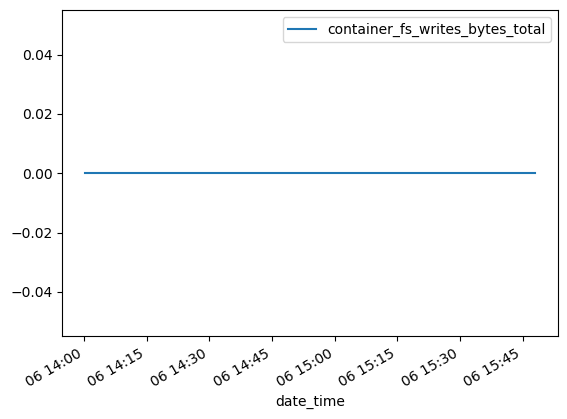

16.741615295410156


In [123]:
comparisson_plot(amf_data, 'container_fs_writes_bytes_total', 'container_fs_writes_bytes_total', 'open5gs-amf-6d85b8c465-fzg2t', 'open5gs-amf-54cc5d554b-pjq4v')

**10. container_fs_writes_total**
--------------------------------------
The container_fs_reads_total metric is a counter that increments each time a container process writes data from the file system. It provides insights into the overall write workload of the container, helping monitor file system access patterns and potential performance bottlenecks related to reading files.<br>

File system writes involve I/O operations, which can consume CPU cycles and require memory for buffering or caching data. Therefore, monitoring CPU and memory utilization alongside file system read metrics can provide a more comprehensive understanding of resource usage patterns within the container. <br>


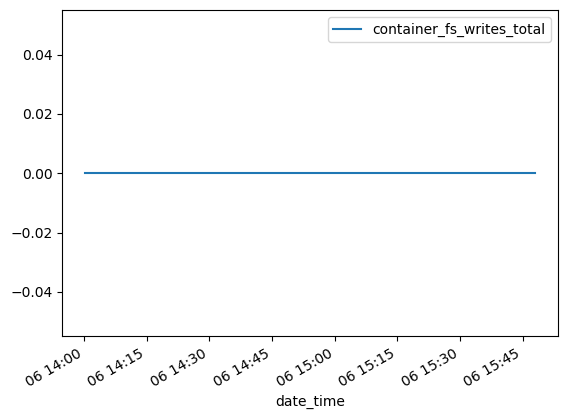

16.797862768173218


In [124]:
comparisson_plot(amf_data, 'container_fs_writes_total', 'container_fs_writes_total', 'open5gs-amf-6d85b8c465-fzg2t', 'open5gs-amf-54cc5d554b-pjq4v')

**FS Features Conclusion**
--------------------------------------
None of them are directly related to CPU or Memory Utilization but their activity can be an indicator of CPU or Memory activiy.

**11. container_last_seen**
--------------------------------------
Last time a container was seen by the exporter. The graph is weird. So high chance it's being visualized wrong. But it is not going to be realted to CPU and memory utilization <br>


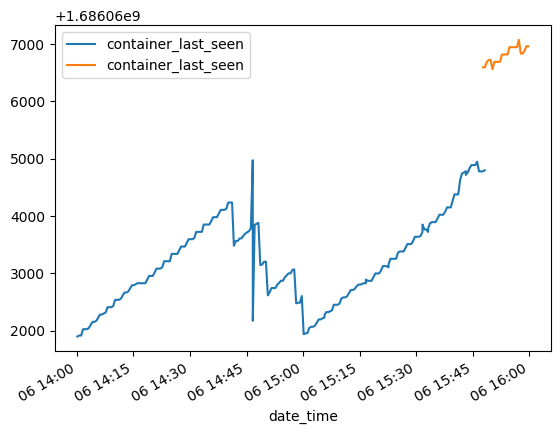

22.244109869003296
+---+--------------------+-------------------+------------+-------------------+
|pos|          metric_pod|    metric___name__|      values|          date_time|
+---+--------------------+-------------------+------------+-------------------+
|  0|open5gs-amf-6d85b...|container_last_seen|1.68606362E9|2023-06-06 14:00:09|
|  0|open5gs-amf-6d85b...|container_last_seen|1.68606003E9|2023-06-06 14:00:09|
|  0|open5gs-amf-6d85b...|container_last_seen|1.68606362E9|2023-06-06 14:00:09|
|  0|open5gs-amf-6d85b...|container_last_seen|1.68606003E9|2023-06-06 14:00:09|
|  0|open5gs-amf-6d85b...|container_last_seen|1.68606003E9|2023-06-06 14:00:09|
|  0|open5gs-amf-6d85b...|container_last_seen|1.68606246E9|2023-06-06 14:00:09|
|  0|open5gs-amf-6d85b...|container_last_seen|1.68606349E9|2023-06-06 14:00:09|
|  0|open5gs-amf-6d85b...|container_last_seen|1.68606003E9|2023-06-06 14:00:09|
|  0|open5gs-amf-6d85b...|container_last_seen|1.68606003E9|2023-06-06 14:00:09|
|  0|open5gs-amf-6d85

In [133]:
comparisson_plot(amf_data, 'container_last_seen', 'container_last_seen', 'open5gs-amf-6d85b8c465-fzg2t', 'open5gs-amf-54cc5d554b-pjq4v')
amf_data.filter(col('metric___name__') == 'container_last_seen').show()

**12. container_memory_cache**
--------------------------------------
The container_memory_cache metric in Prometheus is used to monitor the amount of memory used for caching purposes by container processes within a containerized environment. It provides insights into the portion of memory utilized for caching data from disk or other I/O operations.<br>

The container_memory_cache metric is typically reported as a gauge, representing the current size of memory used for caching and does not accumulate or track cumulative values over time. Caching helps improve performance by storing frequently accessed data in memory, reducing the need to fetch it from slower storage devices. <br>

By monitoring the container_memory_cache metric, you can track the memory consumption dedicated to caching within containers. This can be valuable for understanding the caching behavior of containerized applications and assessing the impact on overall memory utilization. <br>


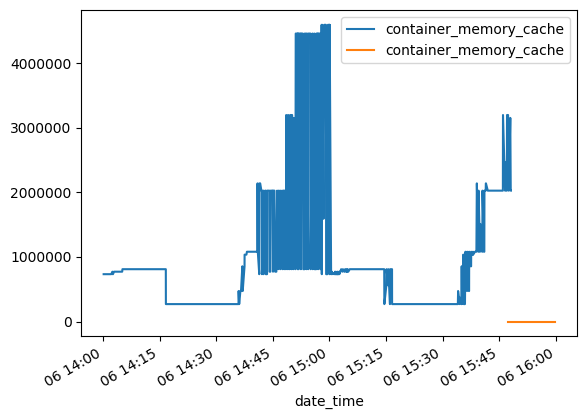

23.585381746292114


In [134]:
comparisson_plot(amf_data, 'container_memory_cache', 'container_memory_cache', 'open5gs-amf-6d85b8c465-fzg2t', 'open5gs-amf-54cc5d554b-pjq4v')

**13. container_memory_failcnt**
--------------------------------------
Tells how many times the container hits memory limit. But this metric of custome type and its data is not recorded.

In [ ]:
comparisson_plot(amf_data, 'container_memory_failcnt', 'container_memory_failcnt', 'open5gs-amf-6d85b8c465-fzg2t', 'open5gs-amf-54cc5d554b-pjq4v')

**14. container_memory_failures_total**
--------------------------------------


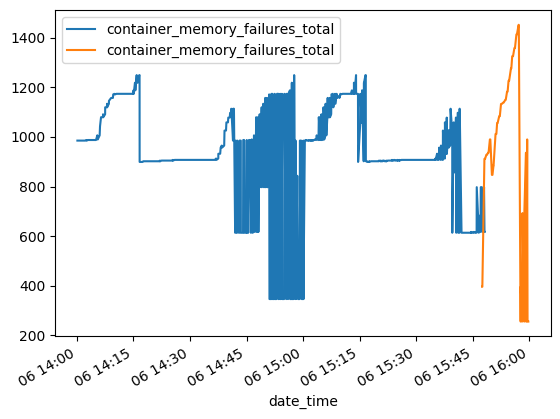

23.108911275863647


In [140]:
comparisson_plot(amf_data, 'container_memory_failures_total', 'container_memory_failures_total', 'open5gs-amf-6d85b8c465-fzg2t', 'open5gs-amf-54cc5d554b-pjq4v')

**15. container_memory_mapped_file**
--------------------------------------

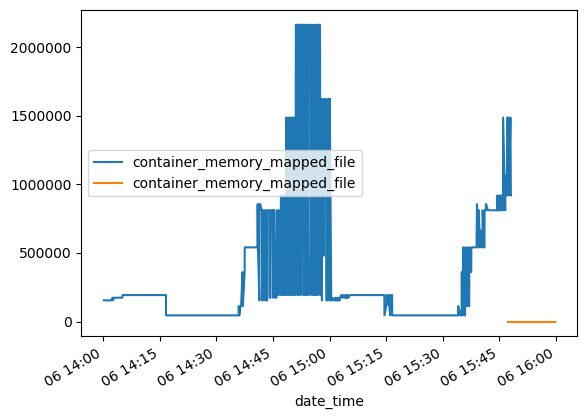

21.920271396636963


In [141]:
comparisson_plot(amf_data, 'container_memory_mapped_file', 'container_memory_mapped_file', 'open5gs-amf-6d85b8c465-fzg2t', 'open5gs-amf-54cc5d554b-pjq4v')

**16. container_memory_max_usage_bytes**
--------------------------------------


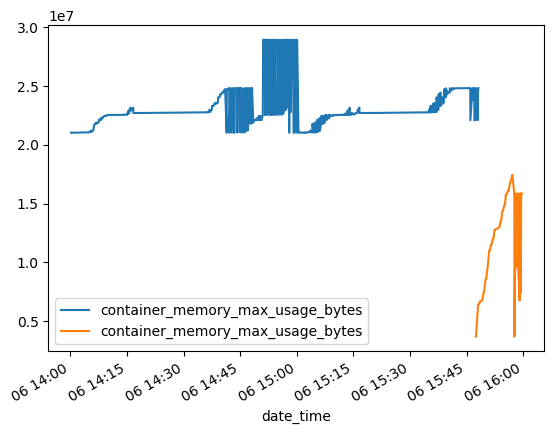

20.392151355743408


In [142]:
comparisson_plot(amf_data, 'container_memory_max_usage_bytes', 'container_memory_max_usage_bytes', 'open5gs-amf-6d85b8c465-fzg2t', 'open5gs-amf-54cc5d554b-pjq4v')

**17. container_memory_usage_bytes**
--------------------------------------

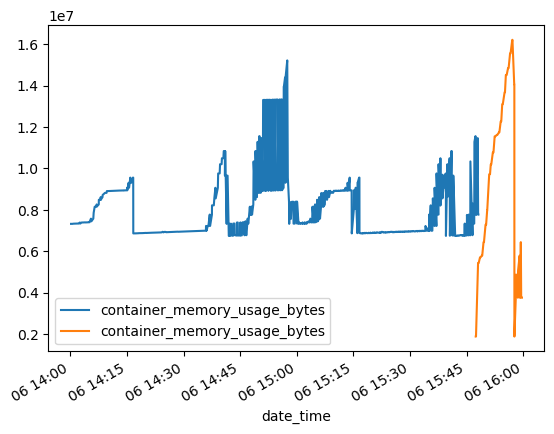

20.955803871154785


In [143]:
comparisson_plot(amf_data, 'container_memory_usage_bytes', 'container_memory_usage_bytes', 'open5gs-amf-6d85b8c465-fzg2t', 'open5gs-amf-54cc5d554b-pjq4v')

**18. container_memory_swap**
--------------------------------------

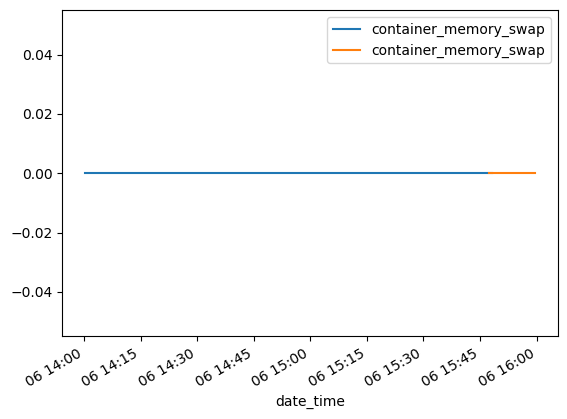

21.11733365058899


In [144]:
comparisson_plot(amf_data, 'container_memory_swap', 'container_memory_swap', 'open5gs-amf-6d85b8c465-fzg2t', 'open5gs-amf-54cc5d554b-pjq4v')

**19. container_memory_working_set_bytes**
--------------------------------------

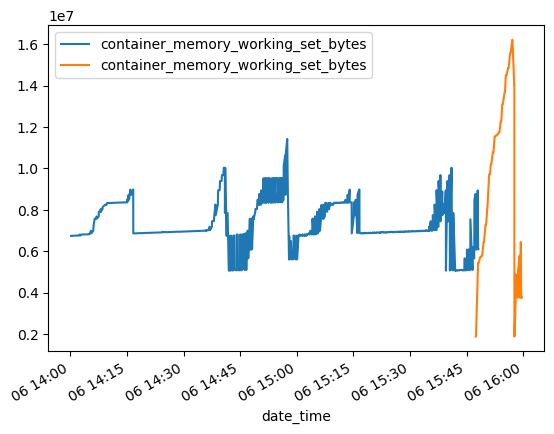

20.332863569259644


In [146]:
comparisson_plot(amf_data, 'container_memory_working_set_bytes', 'container_memory_working_set_bytes', 'open5gs-amf-6d85b8c465-fzg2t', 'open5gs-amf-54cc5d554b-pjq4v')

**20. container_network_receive_bytes_total**
--------------------------------------

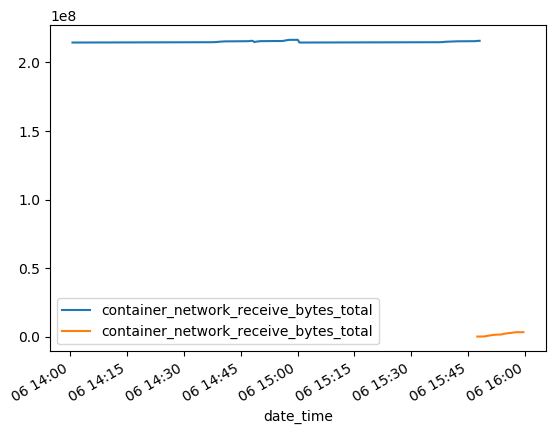

20.352514266967773


In [147]:
comparisson_plot(amf_data, 'container_network_receive_bytes_total', 'container_network_receive_bytes_total', 'open5gs-amf-6d85b8c465-fzg2t', 'open5gs-amf-54cc5d554b-pjq4v')

**21. container_network_receive_packets_total**
--------------------------------------

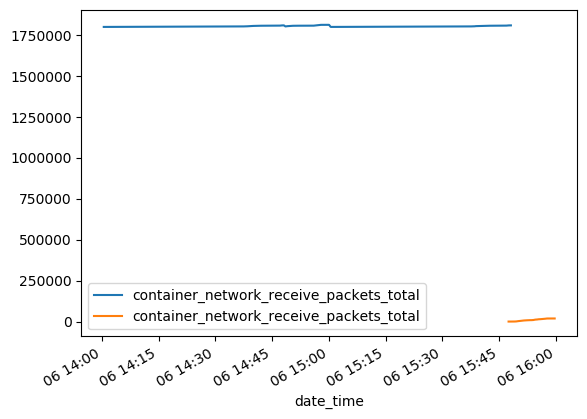

20.417611122131348


In [148]:
comparisson_plot(amf_data, 'container_network_receive_packets_total', 'container_network_receive_packets_total', 'open5gs-amf-6d85b8c465-fzg2t', 'open5gs-amf-54cc5d554b-pjq4v')

**23. container_network_transmit_bytes_total**
-------------------------------------
Tells how many times the container hits memory limit. But this metric of custome type and its data is not recorded.

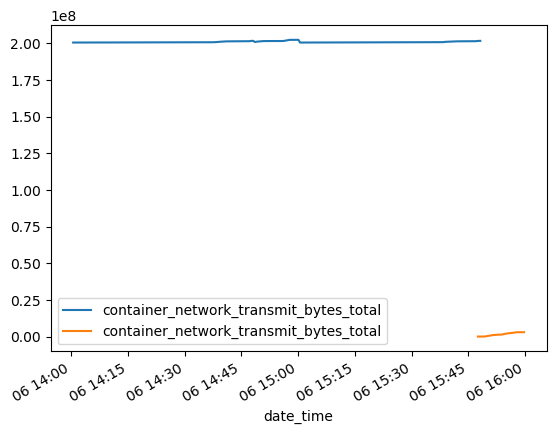

19.917083501815796


In [149]:
comparisson_plot(amf_data, 'container_network_transmit_bytes_total', 'container_network_transmit_bytes_total', 'open5gs-amf-6d85b8c465-fzg2t', 'open5gs-amf-54cc5d554b-pjq4v')

**24. container_network_transmit_errors_total**
--------------------------------------

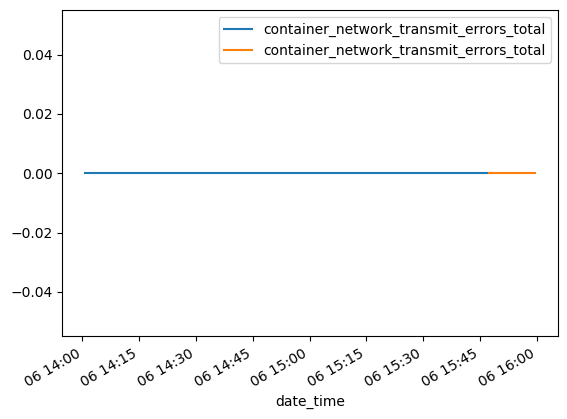

19.610597133636475


In [150]:
comparisson_plot(amf_data, 'container_network_transmit_errors_total', 'container_network_transmit_errors_total', 'open5gs-amf-6d85b8c465-fzg2t', 'open5gs-amf-54cc5d554b-pjq4v')

**25. container_network_transmit_packets_dropped_total**
--------------------------------------

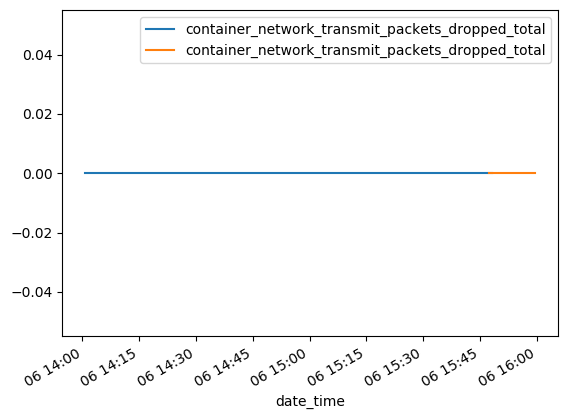

19.42885398864746


In [151]:
comparisson_plot(amf_data, 'container_network_transmit_packets_dropped_total', 'container_network_transmit_packets_dropped_total', 'open5gs-amf-6d85b8c465-fzg2t', 'open5gs-amf-54cc5d554b-pjq4v')

**26. container_network_transmit_packets_total**
--------------------------------------

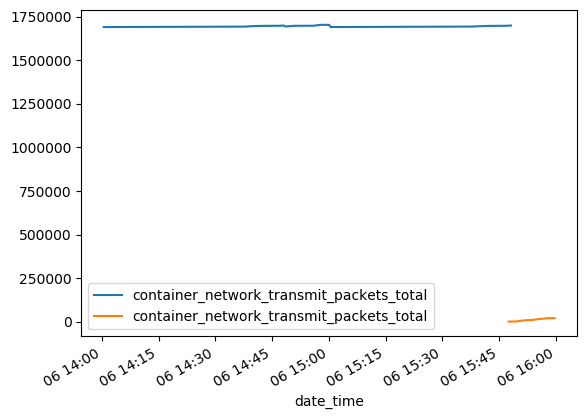

19.86331534385681


In [152]:
comparisson_plot(amf_data, 'container_network_transmit_packets_total', 'container_network_transmit_packets_total', 'open5gs-amf-6d85b8c465-fzg2t', 'open5gs-amf-54cc5d554b-pjq4v')

**27. container_oom_events_total**
--------------------------------------

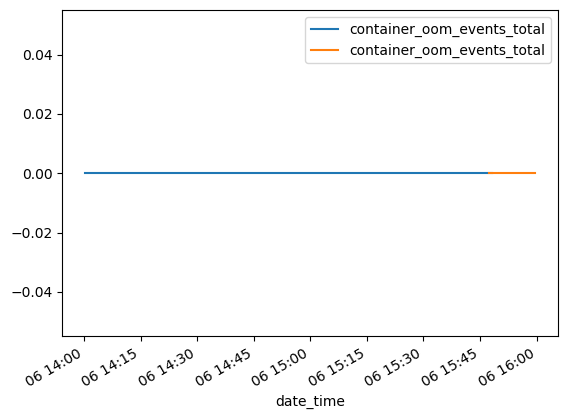

19.589905261993408


In [153]:
comparisson_plot(amf_data, 'container_oom_events_total', 'container_oom_events_total', 'open5gs-amf-6d85b8c465-fzg2t', 'open5gs-amf-54cc5d554b-pjq4v')

**28. container_processes**
--------------------------------------

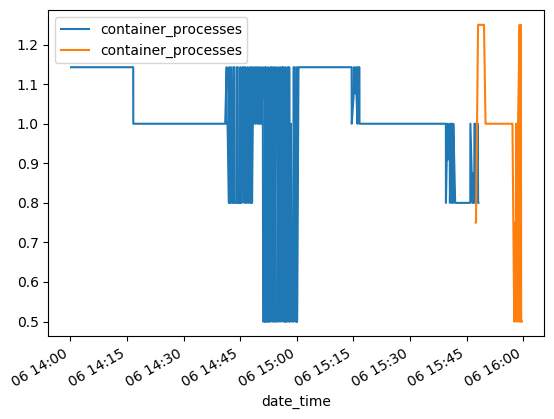

19.538612127304077


In [154]:
comparisson_plot(amf_data, 'container_processes', 'container_processes', 'open5gs-amf-6d85b8c465-fzg2t', 'open5gs-amf-54cc5d554b-pjq4v')

**29. container_sockets**
--------------------------------------

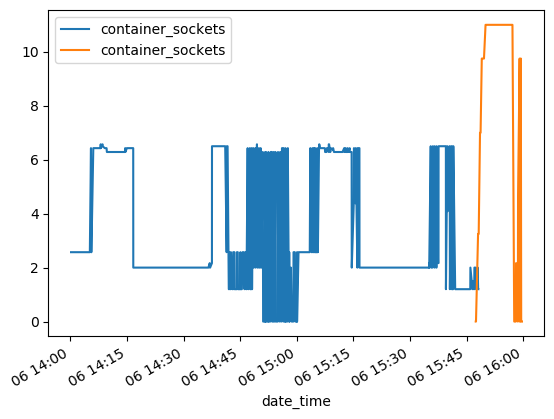

20.000058889389038


In [155]:
comparisson_plot(amf_data, 'container_sockets', 'container_sockets', 'open5gs-amf-6d85b8c465-fzg2t', 'open5gs-amf-54cc5d554b-pjq4v')

Q. When is the time interval between a pod transition ?


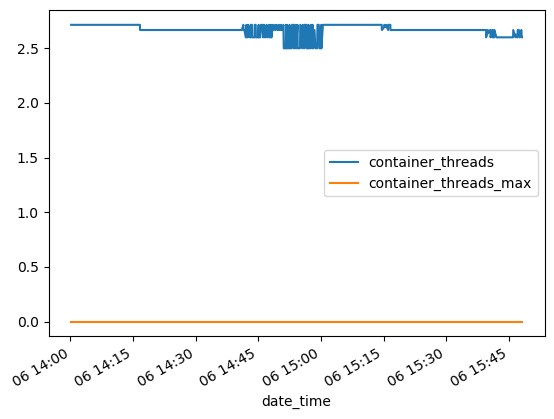

20.11312961578369


In [24]:
comparisson_plot(amf_data, 'container_threads', 'container_threads_max', 'open5gs-amf-6d85b8c465-fzg2t', 'open5gs-amf-6d85b8c465-fzg2t')

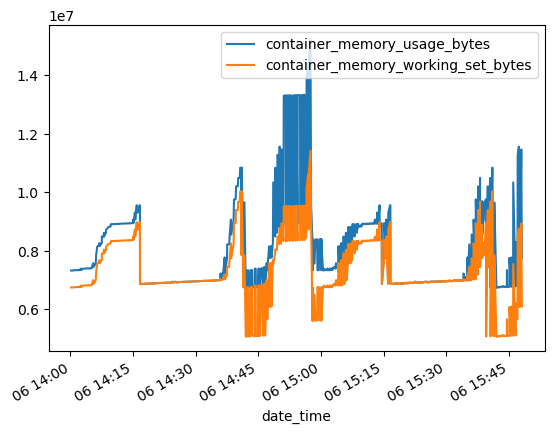

20.200387477874756


In [25]:
comparisson_plot(amf_data, 'container_memory_usage_bytes', 'container_memory_working_set_bytes', 'open5gs-amf-6d85b8c465-fzg2t', 'open5gs-amf-6d85b8c465-fzg2t')

Why is there a fluctuation between 14:45 and 15 ?

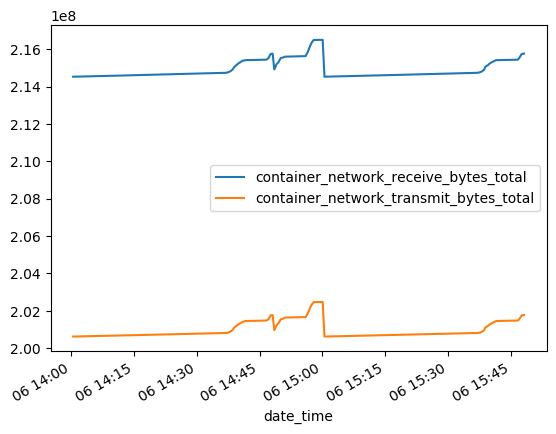

19.798514127731323


In [26]:
comparisson_plot(amf_data, 'container_network_receive_bytes_total', 'container_network_transmit_bytes_total', 'open5gs-amf-6d85b8c465-fzg2t', 'open5gs-amf-6d85b8c465-fzg2t')

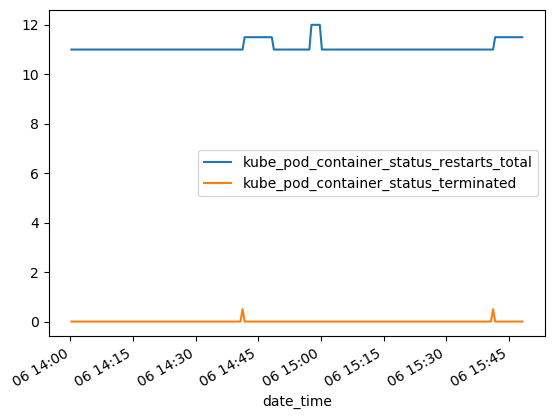

20.311317443847656


In [28]:
comparisson_plot(amf_data, 'kube_pod_container_status_restarts_total', 'kube_pod_container_status_terminated', 'open5gs-amf-6d85b8c465-fzg2t', 'open5gs-amf-6d85b8c465-fzg2t')

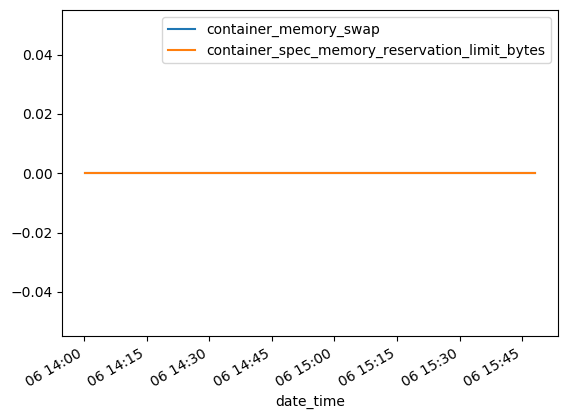

22.397860527038574


In [29]:
comparisson_plot(amf_data, 'container_memory_swap', 'container_spec_memory_reservation_limit_bytes', 'open5gs-amf-6d85b8c465-fzg2t', 'open5gs-amf-6d85b8c465-fzg2t')

In [35]:
amf_data.show()

+---+--------------------+--------------------+---------+-------------------+
|pos|          metric_pod|     metric___name__|   values|          date_time|
+---+--------------------+--------------------+---------+-------------------+
|  0|open5gs-amf-6d85b...|container_blkio_d...|      0.0|2023-06-06 14:00:09|
|  0|open5gs-amf-6d85b...|container_blkio_d...|4276224.0|2023-06-06 14:00:09|
|  0|open5gs-amf-6d85b...|container_blkio_d...|      0.0|2023-06-06 14:00:09|
|  0|open5gs-amf-6d85b...|container_blkio_d...| 344064.0|2023-06-06 14:00:09|
|  0|open5gs-amf-6d85b...|container_blkio_d...| 339968.0|2023-06-06 14:00:09|
|  0|open5gs-amf-6d85b...|container_blkio_d...| 344064.0|2023-06-06 14:00:09|
|  0|open5gs-amf-6d85b...|container_blkio_d...| 339968.0|2023-06-06 14:00:09|
|  0|open5gs-amf-6d85b...|container_blkio_d...| 344064.0|2023-06-06 14:00:09|
|  0|open5gs-amf-6d85b...|container_blkio_d...| 339968.0|2023-06-06 14:00:09|
|  0|open5gs-amf-6d85b...|container_blkio_d...|      0.0|2023-06

In [ ]:
amf_data.select(')